## Goal: Which long SIRVs do we detect? What does their coverage look like over the length of their bodies?

In [126]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [127]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            strip_text_x=element_text(size=base_size + 1.5, family='Helvetica'),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [128]:
config = load_config()
od = '../'
meta_df = load_meta()
meta_df['lab_sample'] = meta_df['lab_number_sample'].astype(str)+'_'+\
                        meta_df['lab_sampleid']+'_'+\
                        meta_df['cell_line_id']


def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [129]:
init_plot_settings()
pop_c_dict, pop_order = get_population_colors()

## SQANTI reads processing

In [157]:
## SQANTI reads stuff
f = proc_cfg(expand(config['lr']['qc_sirvs']['sqanti_reads']['class_summary'],
                    annot_completeness='C')[0], od)
df = pd.read_csv(f, sep='\t')

# rename structural categories
m = {'antisense': 'Antisense',
     'full-splice_match': 'FSM',
     'genic': 'Genic', 
     'incomplete-splice_match': 'ISM',
     'intergenic': 'Intergenic',
     'novel_in_catalog': 'NIC',
     'novel_not_in_catalog': 'NNC'}
df['structural_category'] = df.structural_category.map(m)

# add antisense gene ids as assc_gene_2
df['assc_gene_2'] = df.associated_gene
inds = df.loc[df.structural_category=='Antisense'].index
df.loc[inds, 'assc_gene_2'] = df.loc[inds, 'assc_gene_2'].str.split('_', expand=True)[1]

# add relevant metadata
df = df.merge(meta_df[['lab_sample', 'population']], 
              how='left', on='lab_sample')

# add # mapped reads 
df['n_mapped_reads'] = df.groupby('lab_sample')['isoform'].transform('count')

# add spike type
df['spike_type'] = np.nan
df.loc[df.chrom.str.contains('ERCC'), 'spike_type'] = 'ERCC'
df.loc[df.chrom.str.contains('SIRV'), 'spike_type'] = 'SIRV'

spliced_sirvs = ['SIRV1', 'SIRV2', 'SIRV3', 'SIRV4', 'SIRV5', 'SIRV6', 'SIRV7']
df.loc[df.chrom.isin(spliced_sirvs), 'spike_type_2'] = 'spliced_sirv'

# add # spliced sirv reads
df['n_spliced_sirv_reads'] = df.loc[df.spike_type_2=='spliced_sirv'].groupby('lab_sample')['isoform'].transform('count')

# splicing novelty
df['splicing_novelty'] = 'Novel'
df.loc[df.structural_category.isin(['FSM', 'ISM']), 'splicing_novelty'] = 'Known'

# overal known vs. novel
df['overall_nov'] = 'Novel'
df.loc[df.structural_category == 'FSM', 'overall_nov'] = 'Known'

## Ground truth sirv / ercc gtf
gtf_df = pr.read_gtf('../data/qc_sirvs/SIRV_ERCC_longSIRV_multi-fasta_20210507.gtf').df

temp = gtf_df.loc[gtf_df.Chromosome.isin(spliced_sirvs)]
n_spliced_sirvs_tot = len(temp.transcript_id.unique())

# there are 69 spliced sirvs as ground truth

# get the transcript length of each sirv transcript
gtf_df['exon_len'] = gtf_df['End'] - gtf_df['Start']
gtf_df['transcript_len'] = gtf_df.groupby('transcript_id')['exon_len'].transform('sum')

gtf_df['mean_transcript_len'] = gtf_df.groupby('gene_id')['transcript_len'].transform('mean')
gtf_df['med_transcript_len'] = gtf_df.groupby('gene_id')['transcript_len'].transform('median')

# also get number of exons
gtf_df['n_exons'] = gtf_df.groupby('transcript_id')['exon_assignment'].transform('count')
gtf_df['mean_n_exons'] = gtf_df.groupby('gene_id')['n_exons'].transform('mean')
gtf_df['med_n_exons'] = gtf_df.groupby('gene_id')['n_exons'].transform('median')

# also get number of transcripts
gtf_df['n_transcripts'] = gtf_df.groupby('gene_id')['transcript_id'].transform('nunique')

# get # monoexonic transcripts
temp = gtf_df[['gene_id', 'transcript_id', 'n_exons']].groupby(['gene_id', 'n_exons']).nunique().reset_index()
temp = temp.loc[temp.n_exons==1]
temp.drop('n_exons', axis=1, inplace=True)
temp.rename({'transcript_id': 'n_monoexonic_transcripts'}, axis=1, inplace=True)
temp.loc[temp.gene_id=='SIRV6']
gtf_df = gtf_df.merge(temp,
                      how='left',
                      on='gene_id')

# sort the long sirvs at least by length
sirv_order = ['1', '2', '3', '4', '5', '6', '7',
              '4001', '4002', '4003',
              '6001', '6002', '6003', 
              '8001', '8002', '8003',
              '10001', '10002', '10003',
              '12001', '12002', '12003']
sirv_order = [f'SIRV{s}' for s in sirv_order]

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_77584/2818831187.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ERCC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


## Ground truth -- the sirv / ercc gtf

In [158]:
gtf_df = pr.read_gtf('../data/qc_sirvs/SIRV_ERCC_longSIRV_multi-fasta_20210507.gtf').df

temp = gtf_df.loc[gtf_df.Chromosome.isin(spliced_sirvs)]
n_spliced_sirvs_tot = len(temp.transcript_id.unique())

# there are 69 spliced sirvs as ground truth

# get the transcript length of each sirv transcript
gtf_df['exon_len'] = gtf_df['End'] - gtf_df['Start']
gtf_df['transcript_len'] = gtf_df.groupby('transcript_id')['exon_len'].transform('sum')

gtf_df['mean_transcript_len'] = gtf_df.groupby('gene_id')['transcript_len'].transform('mean')
gtf_df['med_transcript_len'] = gtf_df.groupby('gene_id')['transcript_len'].transform('median')

# also get number of exons
gtf_df['n_exons'] = gtf_df.groupby('transcript_id')['exon_assignment'].transform('count')
gtf_df['mean_n_exons'] = gtf_df.groupby('gene_id')['n_exons'].transform('mean')
gtf_df['med_n_exons'] = gtf_df.groupby('gene_id')['n_exons'].transform('median')

# also get number of transcripts
gtf_df['n_transcripts'] = gtf_df.groupby('gene_id')['transcript_id'].transform('nunique')

# get # monoexonic transcripts
temp = gtf_df[['gene_id', 'transcript_id', 'n_exons']].groupby(['gene_id', 'n_exons']).nunique().reset_index()
temp = temp.loc[temp.n_exons==1]
temp.drop('n_exons', axis=1, inplace=True)
temp.rename({'transcript_id': 'n_monoexonic_transcripts'}, axis=1, inplace=True)
temp.loc[temp.gene_id=='SIRV6']
gtf_df = gtf_df.merge(temp,
                      how='left',
                      on='gene_id')

# sort the long sirvs at least by length
sirv_order = ['1', '2', '3', '4', '5', '6', '7',
              '4001', '4002', '4003',
              '6001', '6002', '6003', 
              '8001', '8002', '8003',
              '10001', '10002', '10003',
              '12001', '12002', '12003']
sirv_order = [f'SIRV{s}' for s in sirv_order]

# label sirv type
long_sirvs = ['4001', '4002', '4003',
              '6001', '6002', '6003', 
              '8001', '8002', '8003',
              '10001', '10002', '10003',
              '12001', '12002', '12003']
long_sirvs = [f'SIRV{s}' for s in long_sirvs]
gtf_df['sirv_type'] = np.nan
gtf_df.loc[gtf_df.Chromosome.isin(long_sirvs), 'sirv_type'] = 'long_sirv'

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_77584/3801397295.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'long_sirv' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


## Detection -- use SQANTI reads

In [167]:
temp = df.loc[df.chrom.isin(long_sirvs)]
temp = temp[['chrom', 'lab_sample']].drop_duplicates()
n_total_long_sirvs = len(long_sirvs)
print(n_total_long_sirvs)

15


In [168]:
temp = temp.groupby('lab_sample').nunique().reset_index().rename({'chrom':'n_det_long_sirvs'}, axis=1)
temp['n_total_long_sirvs'] = n_total_long_sirvs
temp['perc'] = (temp['n_det_long_sirvs']/temp['n_total_long_sirvs'])*100

In [169]:
temp

,lab_sample,n_det_long_sirvs,n_total_long_sirvs,perc
0,10_NI5_GM19117,7,15,46.666667
1,11_NI6_GM19129,11,15,73.333333
2,12_NI7_GM19240,14,15,93.333333
3,13_CH1_GM18542,15,15,100.000000
4,14_CH2_GM18561,7,15,46.666667
5,15_CH3_GM18631,10,15,66.666667
6,16_CH4_GM18772,11,15,73.333333
7,17_CH5_GM18774,10,15,66.666667
8,18_CH6_HG00621,13,15,86.666667
9,19_KE1_GM19307,11,15,73.333333


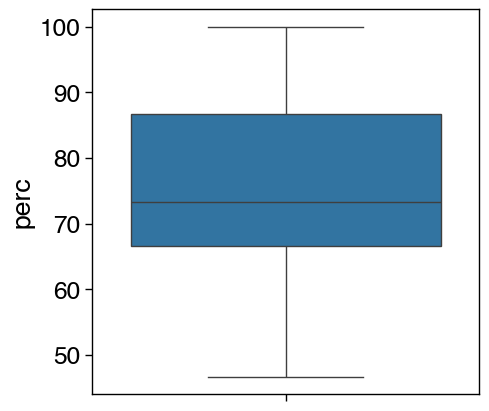

In [171]:
sns.boxplot(temp,
            y='perc')
plt.show()

In [172]:
temp.perc.median()

np.float64(73.33333333333333)

In [174]:
temp.n_det_long_sirvs.median()

np.float64(11.0)

## Coverage

In [176]:
f = proc_cfg(expand(config['lr']['qc_sirvs']['bed_summary'],
                    annot_completeness='C')[0], od)
df = pr.read_bed(f).df
df.rename({'ThickStart': 'lab_sample'}, axis=1, inplace=True)

# limit to the long sirvs
df = df.loc[df.Chromosome.isin(long_sirvs)]
df.Chromosome.unique()

['SIRV4001', 'SIRV4002', 'SIRV4003', 'SIRV6001', 'SIRV6002', ..., 'SIRV10002', 'SIRV10003', 'SIRV12001', 'SIRV12002', 'SIRV12003']
Length: 15
Categories (93, object): ['ERCC-00002', 'ERCC-00003', 'ERCC-00004', 'ERCC-00009', ..., 'SIRV7', 'SIRV8001', 'SIRV8002', 'SIRV8003']

In [177]:
# df.loc[df.Name.duplicated(keep=False)].sort_values(by='Name').head()

## histogram of coverage

In [209]:
cov_df = pd.DataFrame()

# Iterate over each row to compute coverage
for chrom in df.Chromosome.unique():
    cov_data = []
    chrom_df = df.loc[df.Chromosome==chrom]
    for _, row in chrom_df.iterrows():
        positions = range(row['Start'], row['End'])
        cov_data.extend(positions)

    # for each chromosome make this groupby'd dataframe w/ 
    # counts @ each position
    temp = pd.DataFrame(data=cov_data, columns=['pos'])
    temp['chrom'] = chrom

    # append to whole df
    cov_df = pd.concat([cov_df, temp], axis=0)

# get length bin of each sirv
cov_df['len_bin'] = np.nan
len_bins = [4,6,8,10,12]
len_bin_order = []
for l in len_bins:
    len_bin = f'{l}kb'
    cov_df.loc[cov_df.chrom.str.contains(f'SIRV{l}'), 'len_bin'] = len_bin
    len_bin_order.append(len_bin)
cov_df['len_bin'] = pd.Categorical(cov_df['len_bin'], categories=len_bin_order, ordered=True)


/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_77584/723660540.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4kb' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


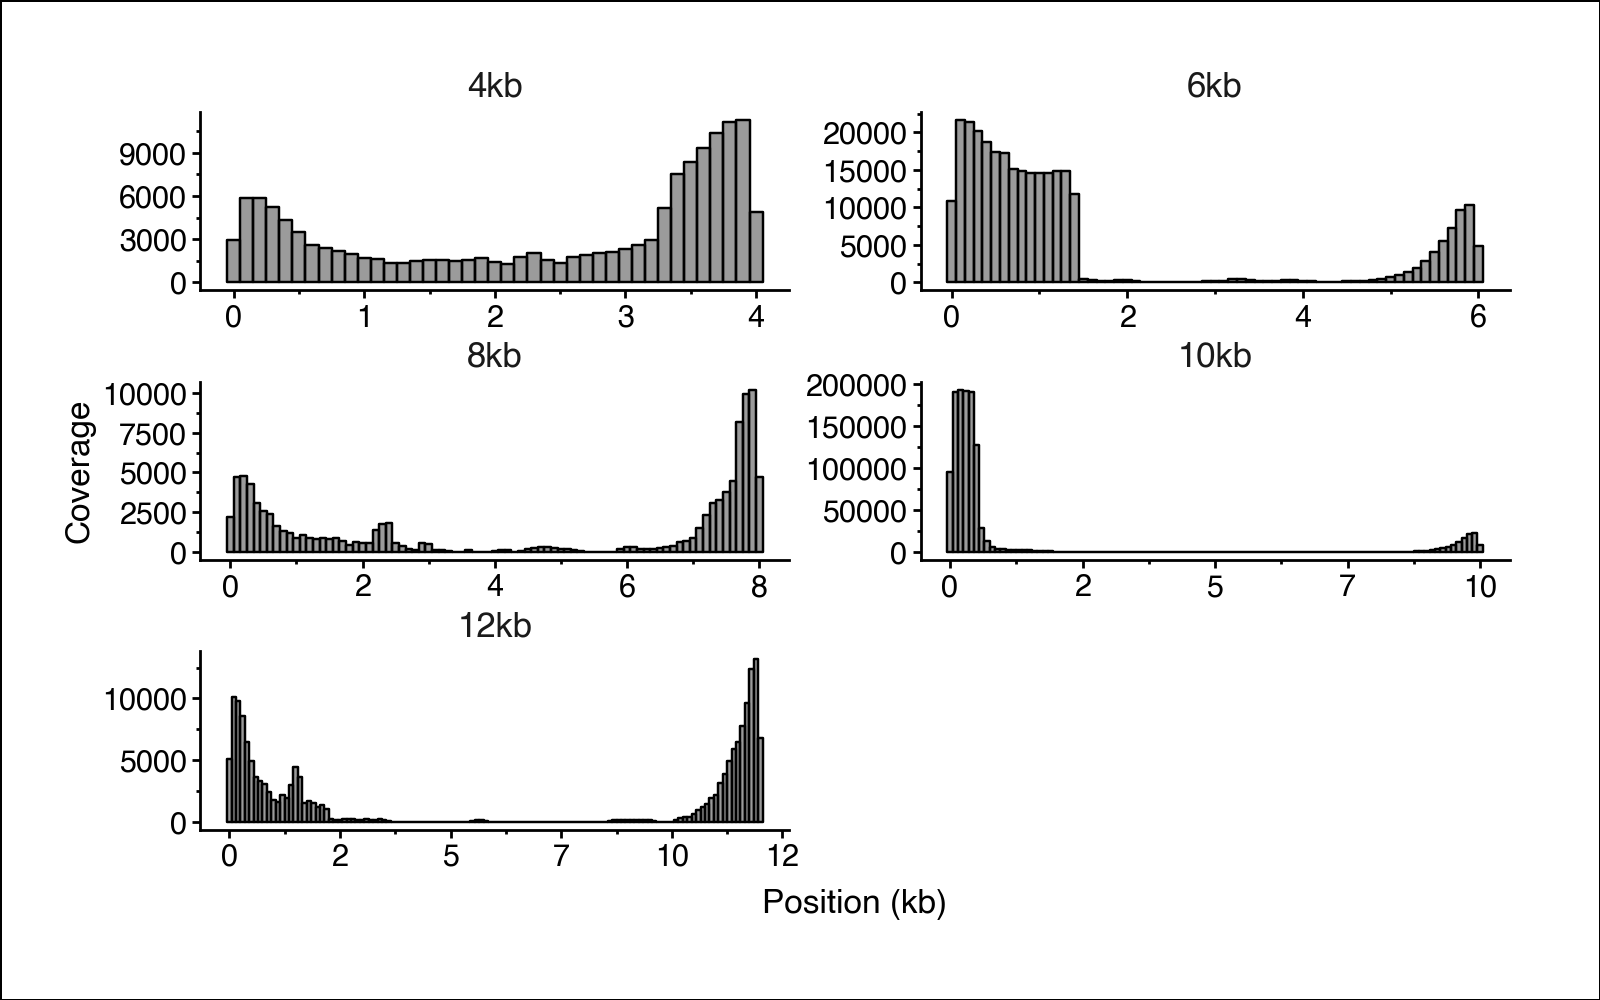

In [210]:

p = (
    ggplot(cov_df, aes(x='pos', color='chrom'))
    + geom_histogram(binwidth=100, position='identity', alpha=0.6, color='black')
    + facet_wrap('~len_bin', ncol=2, scales='free')
    + scale_x_continuous(labels=lambda l: [int(x/1000) for x in l])
    + my_theme(w=8, h=5)
    + labs(title='', x='Position (kb)', y='Coverage')
)

p.show()

### sliding window coverage

In [220]:
import pandas as pd
import numpy as np

window_size = 100  # in bp

cov_df_list = []

for chrom in df.Chromosome.unique():
    chrom_df = df.loc[df.Chromosome == chrom]
    
    # Find max position for chromosome
    chrom_len = chrom_df['End'].max()
    
    # Initialize coverage array
    cov_array = np.zeros(chrom_len, dtype=int)
    
    # Increment coverage counts
    for _, row in chrom_df.iterrows():
        cov_array[row['Start']:row['End']] += 1
    
    # Apply sliding window mean
    rolling_cov = pd.Series(cov_array).rolling(window=window_size, center=True).mean()
    
    # Store in dataframe
    temp_df = pd.DataFrame({
        'pos': np.arange(1, chrom_len + 1),
        'cov': rolling_cov,
        'chrom': chrom
    })
    
    cov_df_list.append(temp_df)

cov_df = pd.concat(cov_df_list, ignore_index=True)

cov_df['len_bin'] = np.nan
len_bins = [4, 6, 8, 10, 12]
len_bin_order = []
for l in len_bins:
    len_bin = f'{l}kb'
    cov_df.loc[cov_df.chrom.str.contains(f'SIRV{l}'), 'len_bin'] = len_bin
    len_bin_order.append(len_bin)
cov_df['len_bin'] = pd.Categorical(cov_df['len_bin'], categories=len_bin_order, ordered=True)
cov_df['chrom'] = pd.Categorical(cov_df['chrom'], categories=long_sirvs, ordered=True)

cov_df['cov'].fillna(0, inplace=True)

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_77584/2520609549.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4kb' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_77584/2520609549.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




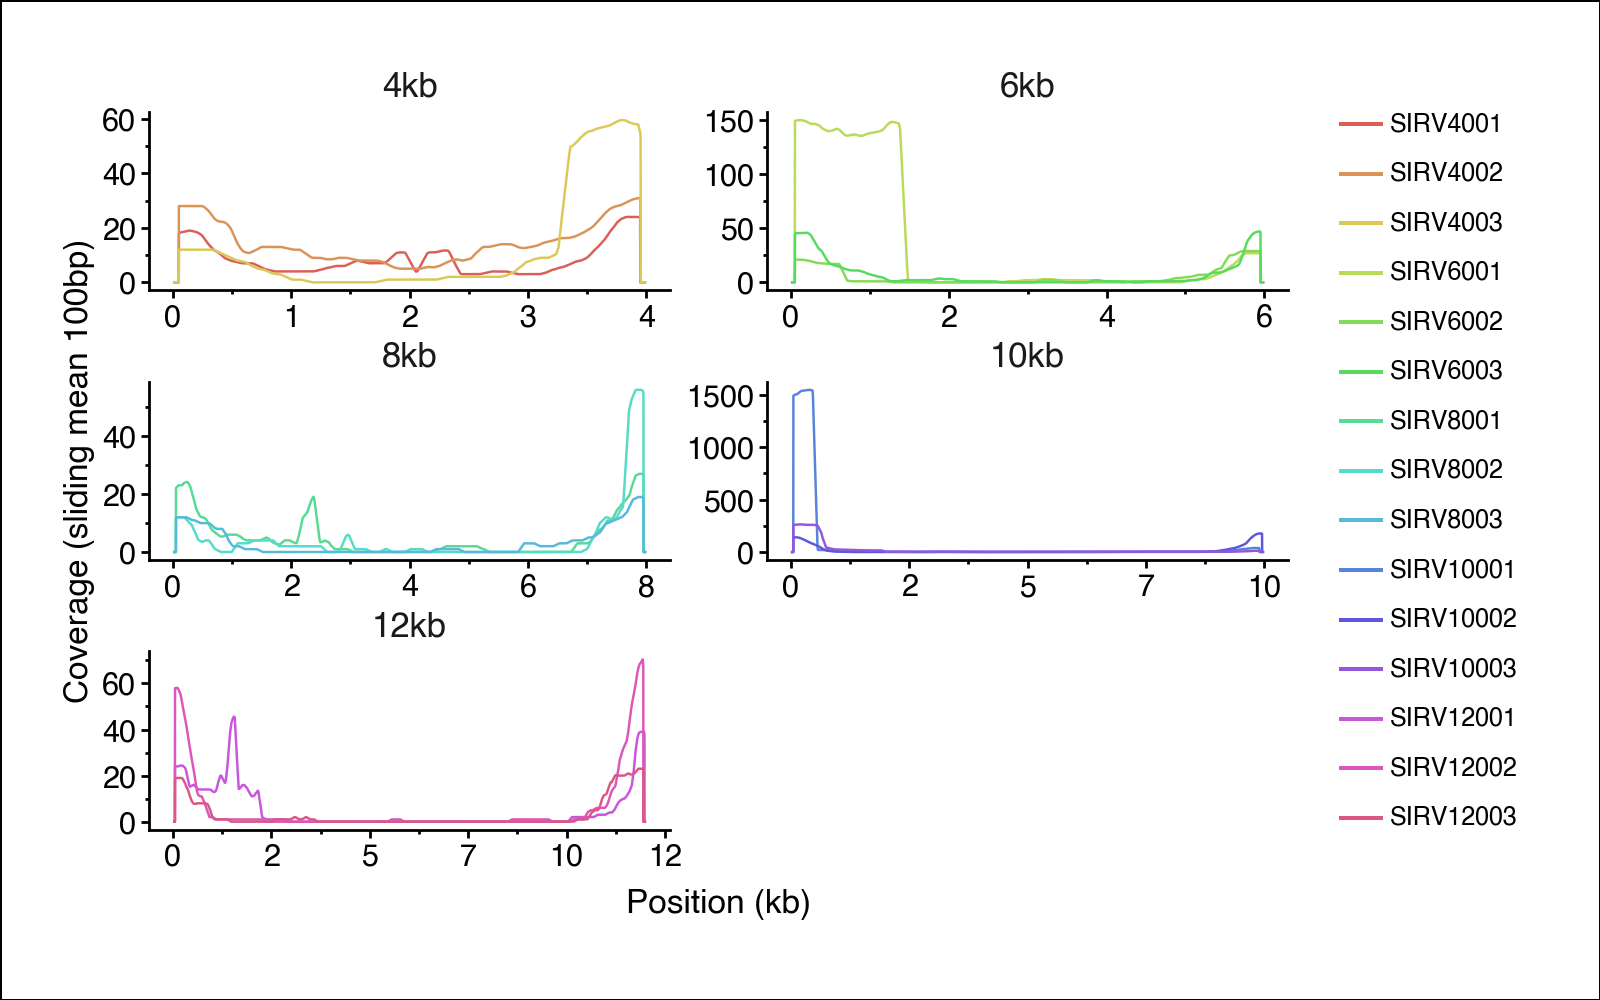

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 5 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: long_sirv_cov.pdf
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [222]:
p = (
    ggplot(cov_df, aes(x='pos', y='cov', color='chrom'))
    + geom_line()
    + facet_wrap('~len_bin', ncol=2, scales='free')
    + scale_x_continuous(labels=lambda l: [int(x/1000) for x in l])
    + scale_color_discrete()
    + my_theme(w=8, h=5)
    + labs(title='', x='Position (kb)', y=f'Coverage (sliding mean {window_size}bp)')
)

p.show()
p.save('long_sirv_cov.pdf', width=8, height=5, dpi=500)


### bp resolution coverage

In [215]:
cov_df = pd.DataFrame()

# Iterate over each row to compute coverage
for chrom in df.Chromosome.unique():
    cov_data = []

    chrom_df = df.loc[df.Chromosome==chrom]
    for _, row in chrom_df.iterrows():
        positions = range(row['Start'], row['End'])
        cov_data.extend(positions)

    # for each chromosome make this groupby'd dataframe w/ 
    # counts @ each position
    temp = pd.Series(cov_data).value_counts().sort_index().reset_index()
    temp.columns = ['pos', 'cov']
    temp['chrom'] = chrom

    # append to whole df
    cov_df = pd.concat([cov_df, temp], axis=0)


cov_df['len_bin'] = np.nan
len_bins = [4, 6, 8, 10, 12]
len_bin_order = []
for l in len_bins:
    len_bin = f'{l}kb'
    cov_df.loc[cov_df.chrom.str.contains(f'SIRV{l}'), 'len_bin'] = len_bin
    len_bin_order.append(len_bin)
cov_df['chrom'] = pd.Categorical(cov_df['chrom'], categories=long_sirvs, ordered=True)
cov_df['len_bin'] = pd.Categorical(cov_df['len_bin'], categories=len_bin_order, ordered=True)


/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_77584/3915694453.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4kb' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


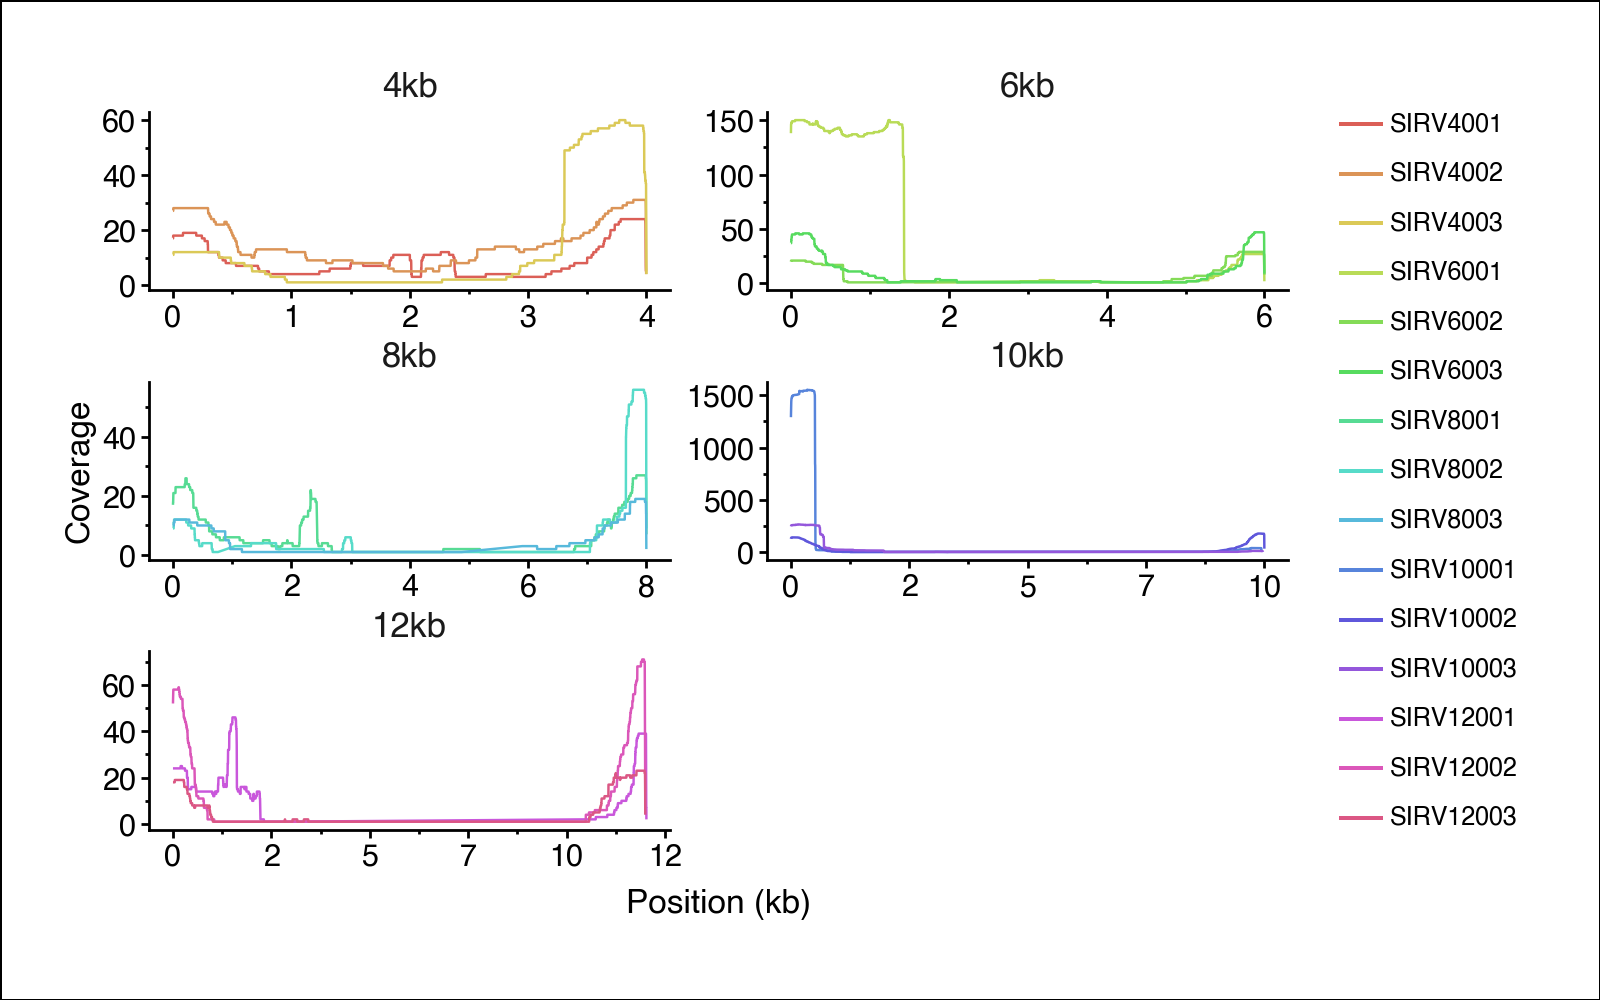

In [216]:
p = (
    ggplot(cov_df, aes(x='pos', y='cov', color='chrom'))
    + geom_line()
    + facet_wrap('~len_bin', ncol=2, scales='free')
    + scale_x_continuous(labels=lambda l: [int(x/1000) for x in l])
    + scale_color_discrete()
    + my_theme(w=8, h=5)
    + labs(title='', x='Position (kb)', y=f'Coverage')
)

p.show()

In [152]:
# gtf_df.loc[gtf_df.sirv_type=='long_sirv'][['Chromosome', 'Strand']].drop_duplicates()

## older

In [101]:
# only long sirvs
temp = df.loc[df.spike_type_2 == 'long_sirv']

AttributeError: 'DataFrame' object has no attribute 'spike_type_2'

In [31]:
temp[['isoform', 'chrom', 'length', 'diff_to_TSS', 'diff_to_TTS', 'diff_to_gene_TSS', 'diff_to_gene_TTS']].head()

,isoform,chrom,length,diff_to_TSS,diff_to_TTS,diff_to_gene_TSS,diff_to_gene_TTS
6856,35faaefb-8556-4c08-b4b3-8d463acf06a2:0,SIRV6001,1432,NaN,NaN,NaN,NaN
6857,1597fa08-13f5-44fc-9a3e-8bc84b42fa35:0,SIRV6001,332,NaN,NaN,NaN,NaN
6858,25104590-1987-48b6-8536-eedd2e8e5806:0,SIRV6001,1419,NaN,NaN,NaN,NaN
6859,a20319a3-52b2-4e33-acac-fc831726eb12:0,SIRV6001,537,NaN,NaN,NaN,NaN
6860,d97178f7-ef5d-420a-8b43-fc37e9cdcb7d:0,SIRV6001,857,-5141.0,-2.0,-5141.0,-2.0


In [25]:
gtf_df.tail()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,transcript_id,...,exon_assignment,exon_len,transcript_len,mean_transcript_len,med_transcript_len,n_exons,mean_n_exons,med_n_exons,n_transcripts,n_monoexonic_transcripts
459,SIRV10002,LexogenSIRVData,exon,0,10001,.,+,0,SIRV10002,SIRV10002,...,SIRV10002_0,10001,10001,10001.0,10001.0,1,1.0,1.0,1,1.0
460,SIRV10003,LexogenSIRVData,exon,0,9970,.,+,0,SIRV10003,SIRV10003,...,SIRV10003_0,9970,9970,9970.0,9970.0,1,1.0,1.0,1,1.0
461,SIRV12001,LexogenSIRVData,exon,0,12029,.,+,0,SIRV12001,SIRV12001,...,SIRV12001_0,12029,12029,12029.0,12029.0,1,1.0,1.0,1,1.0
462,SIRV12002,LexogenSIRVData,exon,0,11999,.,+,0,SIRV12002,SIRV12002,...,SIRV12002_0,11999,11999,11999.0,11999.0,1,1.0,1.0,1,1.0
463,SIRV12003,LexogenSIRVData,exon,0,12000,.,+,0,SIRV12003,SIRV12003,...,SIRV12003_0,12000,12000,12000.0,12000.0,1,1.0,1.0,1,1.0
